# Calculate neutralization for the strains included in the library
Here we compute the  IC50-like measurements for the selections that we performed in a 96-well plate

First, import Python modules:

In [1]:
import os
import altair as alt

import pandas as pd
import yaml
import numpy as np
import neutcurve
from neutcurve import HillCurve

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# allow more rows for Altair
_ = alt.data_transformers.disable_max_rows()

This notebook is parameterized by `papermill`. The next cell is tagged as parameters to get the passed parameters.

In [3]:
# this cell is tagged 'parameters' for `papermill` parameterization
snakemake = None
median_ic50s = None

In [4]:
# Set the input and output paths
if snakemake is not None:
    filepath_prefix = ""
else:
    filepath_prefix = "../../"

with open(filepath_prefix + 'config.yml') as f:
    config = yaml.safe_load(f)

## Read input data for generating dataframe with fraction infectivity measurements
Read configuration:

Read the fraction infectivity measurements calculated from the normalized barcode runs:

In [45]:
# Read in the fraction infectivity files
barcode_runs_df = pd.read_csv(filepath_prefix + config['barcode_runs'])
plates = barcode_runs_df["plate"].unique().tolist()
fractioninfectivity =  pd.concat([
        pd.read_csv(os.path.join(filepath_prefix, config["fraction_infectivity_dir"], f"{plate}_fractioninfectivity.csv"))
        .assign(plate=plate)
        for plate in plates
    ])

# Remove unassigned barcodes from fraction_infectivity file
fractioninfectivity_filtered = fractioninfectivity.dropna()

In [46]:
#fractioninfectivity_filtered = fractioninfectivity_filtered.rename(columns={"serum":"individual"})
#fractioninfectivity_filtered = fractioninfectivity_filtered.rename(columns={"antibody":"serum"})


In [47]:
# Here we are fixing setting every fraction infectivity that is greater than 1 to 1, so as to make the curves a bit easier to look at.
fractioninfectivity_fixtop = fractioninfectivity_filtered
fractioninfectivity_fixtop['fraction infectivity'] = np.where(fractioninfectivity_fixtop['fraction infectivity']>1, 1,fractioninfectivity_fixtop['fraction infectivity'])

In [36]:
# Fit curves to each of the barcoded variants for each sample
fits = neutcurve.CurveFits(fractioninfectivity_fixtop)

## Creating this dataframe from fits.fitParams takes a very long time, this might be improved if we were able to remove bad curves first?

In [37]:
fit_parameters = fits.fitParams()

/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m)**s)
/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/neutcurve/hillcurve.py:741: RuntimeWarning: divide by zero encountered in true_divide
  return b + (t - b) / (1 + (c / m)**s)


In [ ]:
fit_parameters.to_csv(os.path.join(filepath_prefix, config["neutralization_titers_by_barcode"]))

## Now we need to create a dictionary of barcoded strains such that we can call by strain to plot

In [79]:
# Generate a dictionary of barcodes and variants.
# We are using "virus" column here as it already contains the replicate label

barcode_strain = dict(zip(fractioninfectivity_filtered.virus,fractioninfectivity_filtered.strain))

condense = {}
for key,value in barcode_strain.items():
    if value not in condense:
        condense[value] = []
        condense[value].append(key)
    else:
        condense[value].append(key)
               
#To confirm that we have the right number of strains in the library:
output = 'There are ' + str(len(condense)) + ' strains in the library'
print(output)
#condense

There are 36 strains in the library


In [80]:
#Prior to averaging, remove things that have poor slopes
fit_parameters = fit_parameters.loc[fit_parameters['slope']>0]
fit_parameters['strain'] = fit_parameters['virus'].map(barcode_strain)

#Find median NT50 for each strain for each individual this is currently treating all barcodes from replicates in same pool, need to update so that it takes average of NT50 from each replicate for strains that have replicates
median_ic50_frombarcodes = fit_parameters.groupby(['serum','strain','replicate'], as_index=False).median(numeric_only=True)
median_ic50_frombarcodes['NT50'] = 1 / median_ic50_frombarcodes['ic50']
median_ic50_frombarcodes

,serum,strain,replicate,nreplicates,ic50,midpoint,slope,top,bottom,NT50
0,D002d0,A/Bangladesh/2221/2021,average,1.0,0.007591,0.007591,5.076486,1.0,0.0,131.742203
1,D002d0,A/Bangladesh/3210810034/2021,average,1.0,0.002112,0.002112,1.388135,1.0,0.0,473.387020
2,D002d0,A/Bangladesh/8002/2021,average,1.0,0.003815,0.003815,1.252906,1.0,0.0,262.151592
3,D002d0,A/Bangladesh/8036/2021,average,1.0,0.002738,0.002738,1.300548,1.0,0.0,365.184696
4,D002d0,A/Belgium/H0017/2022,average,1.0,0.003473,0.003473,1.768176,1.0,0.0,287.940217
...,...,...,...,...,...,...,...,...,...,...
2911,Y214d30,A/Togo/0304/2021,average,1.0,0.000072,0.000072,5.225541,1.0,0.0,13919.293062
2912,Y214d30,A/Togo/845/2020,average,1.0,0.000086,0.000086,2.846300,1.0,0.0,11660.063991
2913,Y214d30,A/Utah/27/2022,average,1.0,0.000180,0.000180,7.837181,1.0,0.0,5564.258889
2914,Y214d30,A/Washington/23/2020,average,1.0,0.000116,0.000116,4.439063,1.0,0.0,8646.091725


In [103]:
# Creating two dictionary that relates individuals to all sera run from that individual under different conditions so that we can plot all samples for the same individual in the same file
## In addition, a dictionary is created that lists all viruses run for each individual, such that these can be used for plotting

sera = fractioninfectivity_filtered.individual.unique().tolist()

toplot = {}
comparisons_in_dataset = {}
for indiv in sera:
    samples =  fractioninfectivity_filtered.loc[fractioninfectivity_filtered['individual'] == indiv]['serum'].unique().tolist()
    toplot[indiv] = samples
    virusesrun = fractioninfectivity_filtered.loc[fractioninfectivity_filtered['individual'] == indiv]['virus'].unique().tolist()
    comparisons_in_dataset[indiv] = virusesrun


/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1148: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1149: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/fh/fast/bloom_j/computational_notebooks/aloes/2023/flu_NGSNeuts_DRIVE/env/lib/python3.8/site-packages/matplotlib/axes/_axes.py:1148: Ru

KeyboardInterrupt: 

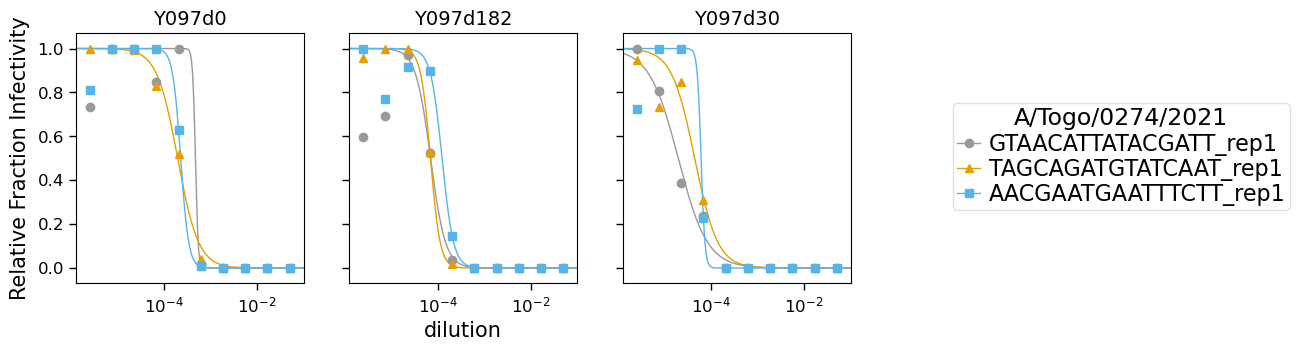

In [97]:
# This step is quite slow, we are creating a pdf for each serum sample, then outputing all the curves for all timepoints to the file. 

for indiv in toplot:
    with PdfPages(os.path.join(filepath_prefix, config["selection_dir"]+"/"+indiv+".pdf")) as pdf:
        for i in condense:
            viruses_for_strain = condense[i]
            viruses_to_plot = [virus for virus in viruses_for_strain if virus in comparisons_in_dataset[indiv]]                
            fig, axes = fits.plotSera(sera=toplot[indiv], viruses=viruses_to_plot,xlabel='dilution',ylabel='Relative Fraction Infectivity',legendfontsize=16,legendtitle=i,max_viruses_per_subplot=8)
            pdf.savefig(bbox_inches='tight')  # saves the current figure into a pdf page
            plt.close()
    plt.close('all')

In [ ]:
if snakemake:
    median_ic50_frombarcodes.to_csv(median_ic50s, index=False)
else:
    median_ic50_frombarcodes.to_csv(os.path.join(filepath_prefix, config["neutralization_titers_by_strain"]))